In [57]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np # scientific computing
import pandas as pd # data loading and processing
import os # os operations
import matplotlib.pyplot as plt # for generating figures
import math
import matplotlib.dates as mdates
import seaborn as sns # for generating visualizations, better support with pandas than matplotlib
from scipy import stats
from sklearn.impute import SimpleImputer

from analysis import *

In [3]:
data, hccdb = get_raw_data()

/Users/shanghongsim/Documents/GitHub/HU-ATRi-Code-Repository/analysis.py:17: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(n1, index_col = 1, sep = "\t").drop(["Entrez_ID"], axis=1) # gene x patient


(11060, 20534)
(11069, 20531)


In [4]:
analyses = ["RRM2B - NRF2 sig",
            "RRM2B - AOS sig",
            "RRM2B - G6PD",
            "RRM2B - p53 sig",
            "p53 sig - G6PD",
            ]
aos_set = ['STAD', 'HNSC', 'SARC', 'UCS', 
           'LUSC', 'BRCA','Aggregated']
liver_set = ['LIHC','HCCDB-1', 'HCCDB-3', 'HCCDB-4','HCCDB-9','HCCDB-13','HCCDB-14', 'HCCDB-16', 'HCCDB-17']
p53_set = ['STAD', 'HNSC', 'LUSC']

In [5]:
# def rrm2b_aos(x="RRM2B", y="AOS", db=["PANCAN"]):

#     # master script to screen (publication) cancers for RRM2B - AOS

#     # load gene names
#     gene_set = get_gene_sets()
#     x_set, y_set, targets = get_xy_set(gene_set, xvar=x,yvar=y)

#     # load database names
#     databases = db

#     # define subplot grid
#     fig, axs = plt.subplots(2, 4, figsize=(28, 14), sharey=True)
#     plt.subplots_adjust(hspace=0.6)
#     title = 'RRM2B vs antioxidant signature'
#     fig.suptitle(title,fontsize = 25)

#     # main loop
#     for db, ax in zip(databases, axs.ravel()):
#         print(db)
#         df = get_data(data, hccdb, db)
#         data_new = process_data(df, targets, x_var_names = ["RRM2B"], y_var_names = gene_set, pheno_filtered=None, outlier_corrected = True)
#         analyse(data_new, fig, db, ax, title + ' screen (publication).png', x_label = "RRM2B", y_label = "Antioxidant signature", dataset_screen = True)
#         axs[1][3].set_visible(False)
#     print("done")


    

In [54]:
[i for i in data.columns.to_list() if i.startswith("GGT")] 

['GGT1', 'GGT3P', 'GGT5', 'GGT6', 'GGT7', 'GGT8P', 'GGTA1', 'GGTLC1', 'GGTLC2']

In [53]:
"GGT2" in data.columns.to_list()

False

In [58]:
def rrm2b_aos(x="RRM2B", y="AOS", db=["PANCAN"]):
    # master script to screen (publication) cancers for RRM2B - AOS

    # load gene names
    gene_set = get_gene_sets()
    x_set, y_set, targets = get_xy_set(gene_set, xvar=x,yvar=y)

    # load database names
    databases = db

    # define subplot grid
    fig, axs = plt.subplots(6, 8, figsize=(60, 40), sharey=True)
    plt.subplots_adjust(hspace=0.6)
    title = 'RRM2B vs antioxidant signature'
    fig.suptitle(title,fontsize = 25)

    # main loop
    for db, ax in zip(databases, axs.ravel()):
        print(db)
        df = get_data(data, hccdb, db)
        data_new = process_data(df, targets, x_var_names = x_set, y_var_names = y_set, pheno_filtered=None, outlier_corrected = True)
        analyse(data_new, fig, db, ax, title + ' screen (pancan).png', x_label = x, y_label = y, dataset_screen = True)
    print("done")


PANCAN
entering process data
transposed
                 CHAC1   HBD   GPX4  PXDNL   SELT  KDM3B  SESN1  GSTM1   GPX1  \
TCGA-OR-A5J1-01   5.09  0.00  12.80   0.97  11.62  10.84  11.55   9.12  12.13   
TCGA-OR-A5J2-01   5.09  0.49  11.94   1.14  12.32  11.41   8.65  10.89  11.94   
...                ...   ...    ...    ...    ...    ...    ...    ...    ...   
TCGA-CG-4476-01   8.04  0.44  10.66   3.17  11.26  11.43  10.43   3.07  11.23   
TCGA-CG-4477-01   7.21  2.11  11.30   2.89  11.34  10.99   9.02   9.48  11.66   

                 HBA1  ALOX5AP  PRDX2  APOA4  GPX8   IDH1   GLO1  MGST1  \
TCGA-OR-A5J1-01  7.78     6.40  13.20  0.000  9.37  12.50  12.33  11.18   
TCGA-OR-A5J2-01  1.29     3.36  13.13  0.850  9.16  12.17  11.62   6.41   
...               ...      ...    ...    ...   ...    ...    ...    ...   
TCGA-CG-4476-01  5.19     9.25  11.60  0.762  9.77  11.36  11.06   9.19   
TCGA-CG-4477-01  6.23     9.91  12.11  0.762  8.76  11.23  11.45   9.43   

                 GSTA3

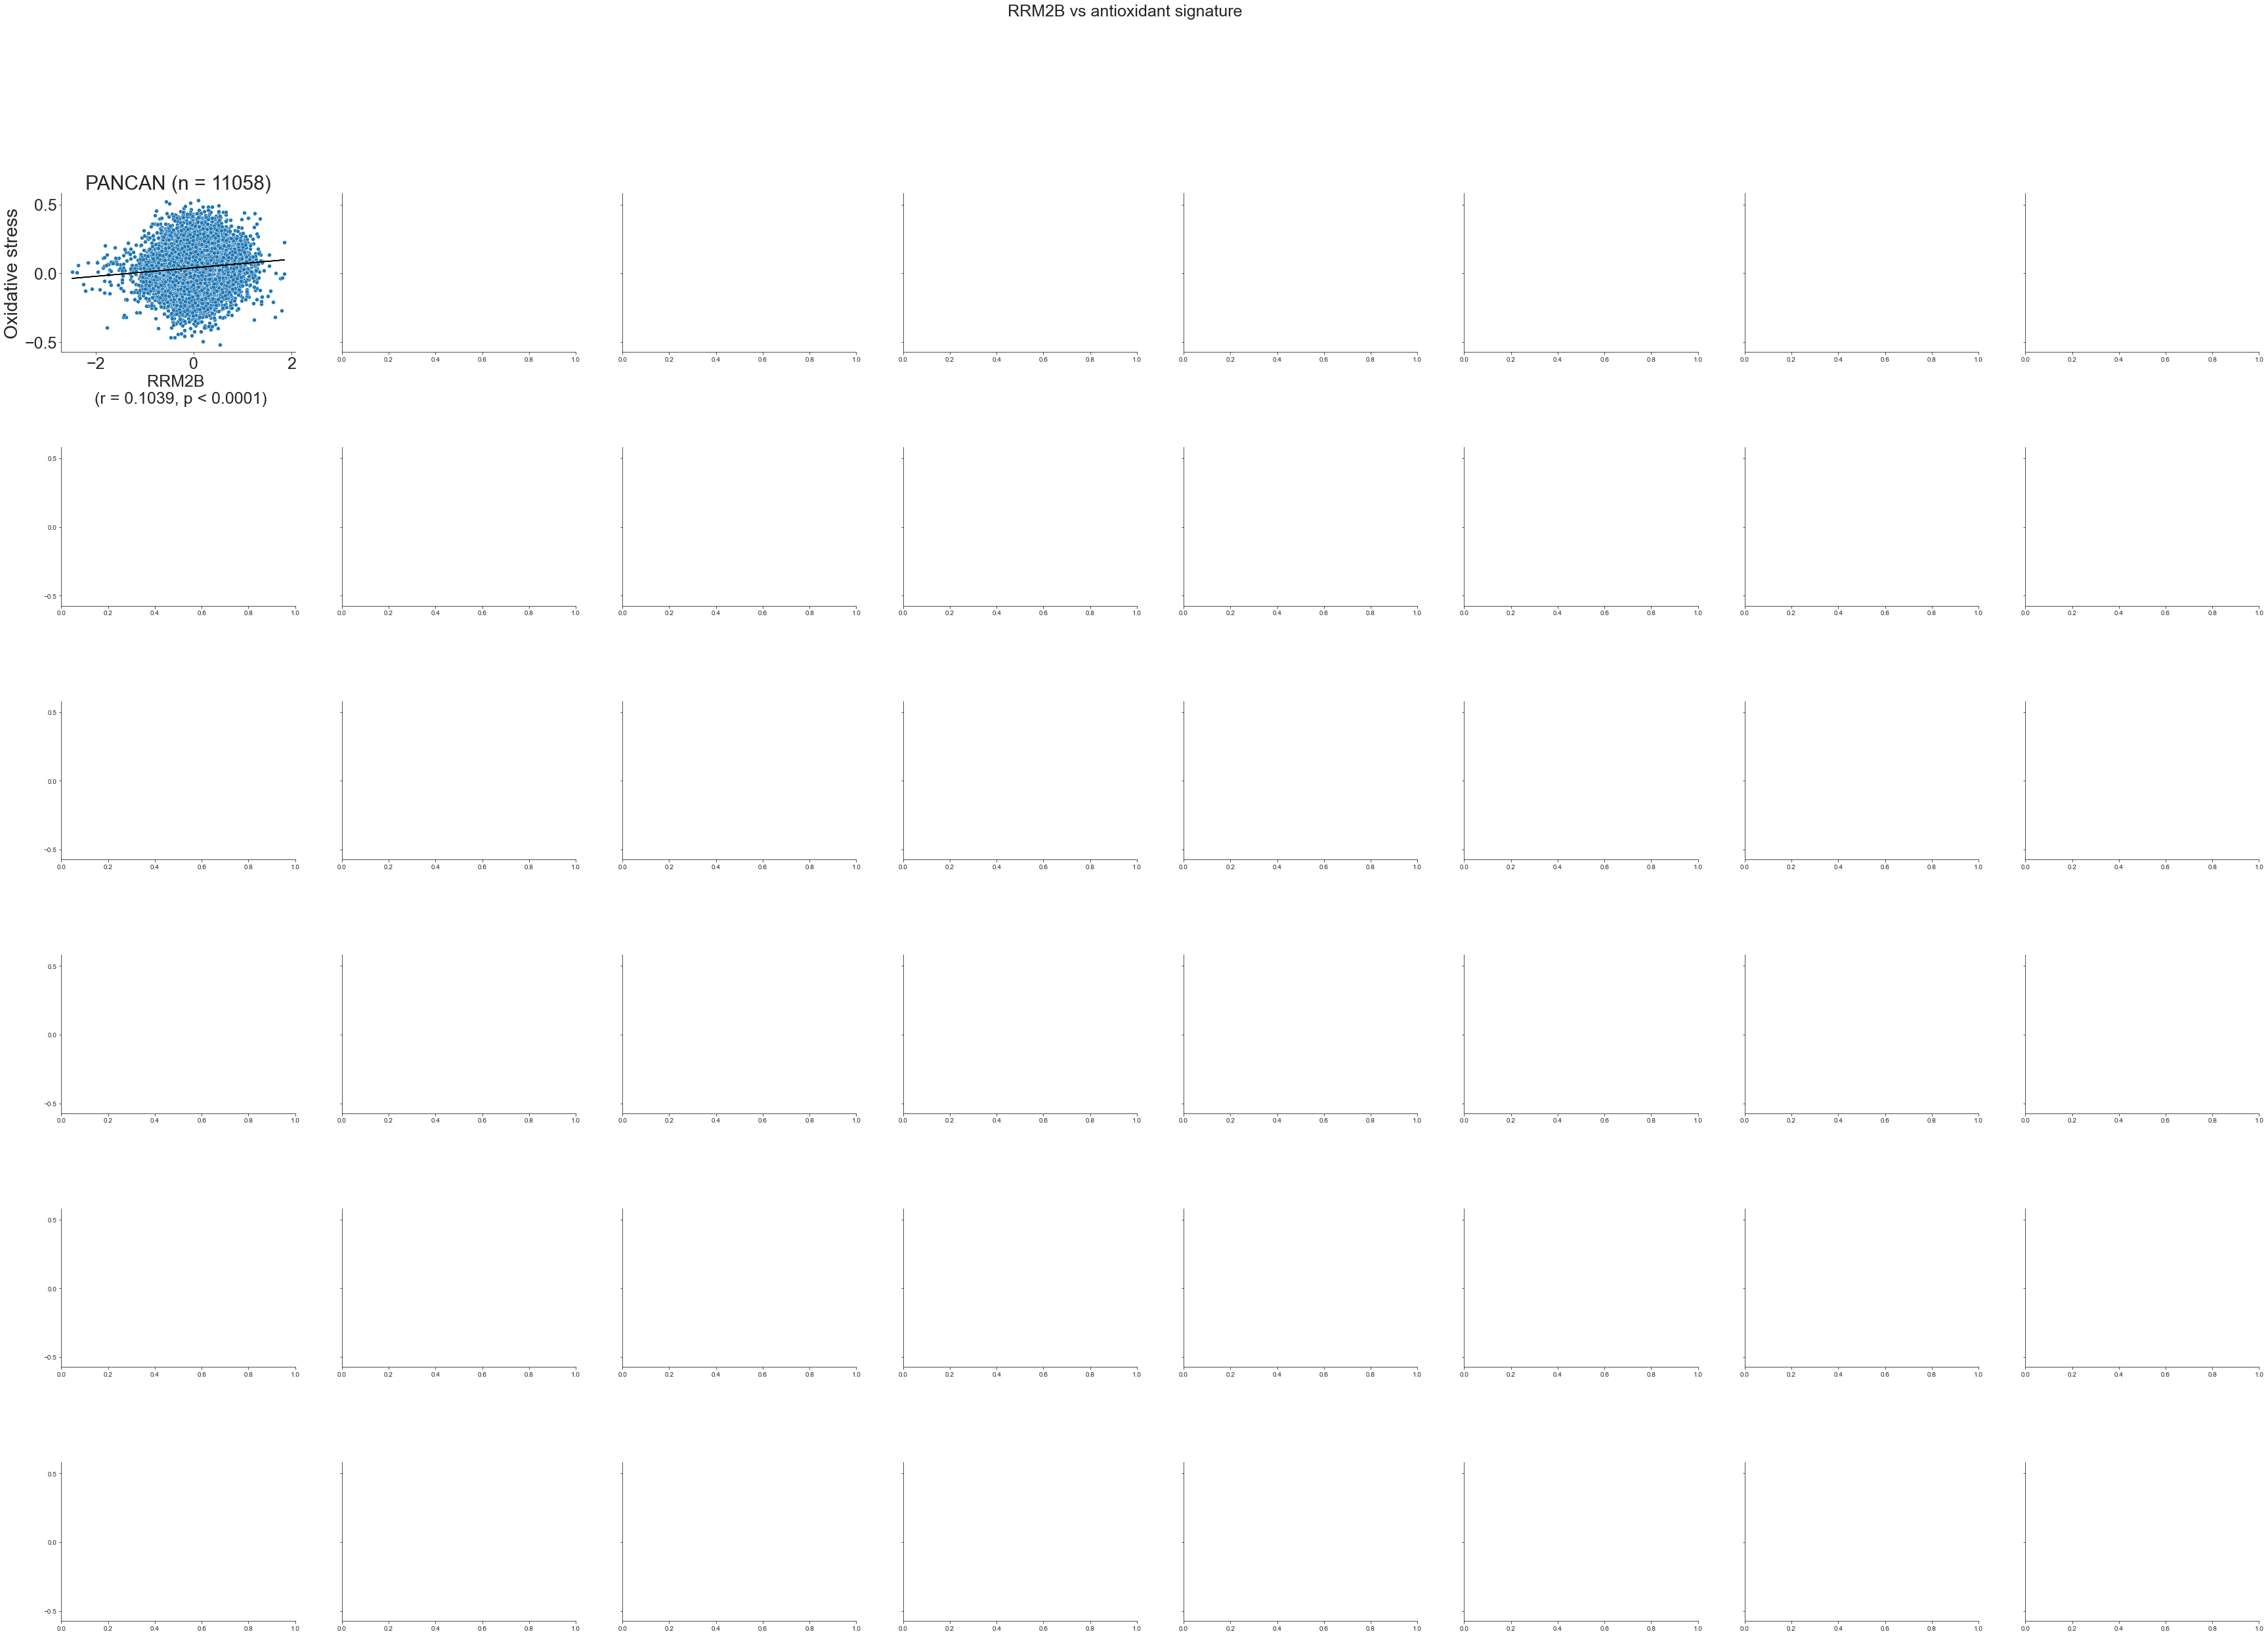

done


In [59]:
rrm2b_aos(x="RRM2B", y="Oxidative stress", db=['PANCAN'])

In [ ]:
# master script to screen cancers for RRM2B - NRF2 signature

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
gene_set = gene_set['NRF2_final'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  gene_set))

databases = aos_set

# define subplot grid
fig, axs = plt.subplots(2, 4, figsize=(28, 14), sharey=True)
plt.subplots_adjust(hspace=0.5)
title = 'RRM2B vs NRF2 signature'
fig.suptitle(title,fontsize = 25)

for db, ax in zip(databases, axs.ravel()):
    print(db)
    df = get_data(data, hccdb, db)
    data_new = process_data(df, targets, x_var_names = ["RRM2B"], y_var_names = gene_set, pheno_filtered=None, outlier_corrected = True)
    analyse(data_new, fig, db, ax, title + ' screen (publication).png', x_label = "RRM2B", y_label = "NRF2 signature", dataset_screen = True)
    axs[1][3].set_visible(False)
print("done")

In [ ]:


# master script to screen cancers for RRM2B - NRF2 signature

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
gene_set = gene_set['NRF2_final'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  gene_set))

databases = aos_set

# define subplot grid
fig, axs = plt.subplots(2, 4, figsize=(28, 14), sharey=True)
plt.subplots_adjust(hspace=0.5)
title = 'RRM2B vs NRF2 signature'
fig.suptitle(title,fontsize = 25)

for db, ax in zip(databases, axs.ravel()):
    print(db)
    df = get_data(data, hccdb, db)
    data_new = process_data(df, targets, x_var_names = ["RRM2B"], y_var_names = gene_set, pheno_filtered=None, outlier_corrected = True)
    analyse(data_new, fig, db, ax, title + ' screen (publication).png', x_label = "RRM2B", y_label = "NRF2 signature", dataset_screen = True)
    axs[1][3].set_visible(False)
print("done")

# # master script to screen cancers for RRM2B - p53 signature

# gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
# gene_set = gene_set['p53 new'].dropna().tolist()

# targets = list(set(["G6PD", "RRM2B"] +  gene_set))

# databases = ['PANCAN'] # , , 'PANCAN'

# # define subplot grid
# fig, axs = plt.subplots(6, 8, figsize=(60, 40), sharey=True)
# plt.subplots_adjust(hspace=0.6)
# title = 'RRM2B vs p53 signature'
# fig.suptitle(title,fontsize = 25)

# for db, ax in zip(databases, axs.ravel()):
#     print(db)
#     df = get_data(data, hccdb, db)
#     data_new = process_data(df, targets, x_var_names = ["RRM2B"], y_var_names = gene_set, pheno_filtered=None, outlier_corrected = True)
#     analyse(data_new, fig, db, ax, title + ' screen (publication).png', x_label = "RRM2B", y_label = "p53 signature", dataset_screen = True)
# print("done")

# master script to screen cancers for NRF2 signature - p53 signature

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
x_set = gene_set['p53 new'].dropna().tolist()
y_set = gene_set['NRF2_final'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  x_set + y_set))

databases = p53_set

# define subplot grid
fig, axs = plt.subplots(1, 3, figsize=(25, 10), sharey=True)
plt.subplots_adjust(hspace=0.6)
title = 'NRF2 signature vs p53 signature'
fig.suptitle(title,fontsize = 25)

for db, ax in zip(databases, axs.ravel()):
    print(db)
    df = get_data(data, hccdb, db)
    data_new = process_data(df, targets, x_var_names = x_set, y_var_names = y_set, pheno_filtered=None, outlier_corrected = True)
    analyse(data_new, fig, db, ax, title + ' screen (publication).png', x_label = "p53 signature", y_label = "NRF2 signature", dataset_screen = True)
print("done")


# master script to screen cancers for AOS signature - p53 signature

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
set_x = gene_set['p53 new'].dropna().tolist()
set_y = gene_set['AOS_final'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  set_x + set_y))

databases = p53_set

# define subplot grid
fig, axs = plt.subplots(1, 3, figsize=(25, 10), sharey=True)
plt.subplots_adjust(hspace=0.6)
title = 'AOS signature vs p53 signature'
fig.suptitle(title,fontsize = 25)

for db, ax in zip(databases, axs.ravel()):
    print(db)
    df = get_data(data, hccdb, db)
    data_new = process_data(df, targets,  set_x, y_var_names = set_y, pheno_filtered=None, outlier_corrected = True)
    analyse(data_new, fig, db, ax, title + ' screen (publication).png', x_label = "p53 signature", y_label = "Antioxidant signature", dataset_screen = True)
print("done")


# master script to screen cancers for p53 signature vs G6PD

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
x_set = gene_set['p53 new'].dropna().tolist()
y_set = gene_set['NRF2_final'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  x_set + y_set))

databases = liver_set 

# define subplot grid
fig, axs = plt.subplots(2, 5, figsize=(28, 10), sharey=True)
plt.subplots_adjust(hspace=0.6)
title = 'p53 signature vs G6PD'
fig.suptitle(title,fontsize = 25)

for db, ax in zip(databases, axs.ravel()):
    print(db)
    df = get_data(data, hccdb, db)
    data_new = process_data(df, targets, x_var_names = x_set, y_var_names = ["G6PD"], pheno_filtered=None, outlier_corrected = True)
    analyse(data_new, fig, db, ax, title + ' screen liver (publication).png', x_label = "p53 signature", y_label = "G6PD", dataset_screen = True)
    axs[1][4].set_visible(False)
print("done")

# master script to screen cancers for p53 signature vs G6PD

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
x_set = gene_set['p53 new'].dropna().tolist()
y_set = gene_set['NRF2_final'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  x_set + y_set))

databases = aos_set 

# define subplot grid
fig, axs = plt.subplots(2, 4, figsize=(28, 14), sharey=True)
plt.subplots_adjust(hspace=0.6)
title = 'p53 signature vs G6PD'
fig.suptitle(title,fontsize = 25)

for db, ax in zip(databases, axs.ravel()):
    print(db)
    df = get_data(data, hccdb, db)
    data_new = process_data(df, targets, x_var_names = x_set, y_var_names = ["G6PD"], pheno_filtered=None, outlier_corrected = True)
    analyse(data_new, fig, db, ax, title + ' screen (publication).png', x_label = "p53 signature", y_label = "G6PD", dataset_screen = True)
    axs[1][3].set_visible(False)
print("done")

# master script to screen cancers for RRM2B vs G6PD

targets = ["G6PD", "RRM2B"]

databases = aos_set

# define subplot grid
fig, axs = plt.subplots(2, 4, figsize=(28, 14), sharey=True)
plt.subplots_adjust(hspace=0.6)
title = 'RRM2B vs G6PD'
fig.suptitle(title,fontsize = 25)

for db, ax in zip(databases, axs.ravel()):
    print(db)
    df = get_data(data, hccdb, db)
    data_new = process_data(df, targets,x_var_names = ["RRM2B"], y_var_names = ["G6PD"], pheno_filtered=None, outlier_corrected = True)
    analyse(data_new, fig, db, ax, title + ' screen (publication).png', x_label = "RRM2B", y_label = "G6PD", dataset_screen = True)
    axs[1][3].set_visible(False)
print("done")


In [ ]:
# # master script to screen cancers for RRM2B vs NRF2 signature

# gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
# gene_set = gene_set['NRF2_final'].dropna().tolist()

# targets = list(set(["G6PD", "RRM2B"] +  gene_set))

# databases = ['PANCAN', 'COAD'] # , , 'PANCAN'

# # define subplot grid
# fig, axs = plt.subplots(6, 8, figsize=(60, 40), sharey=True)
# plt.subplots_adjust(hspace=0.6)
# title = 'RRM2B vs NRF2 signature'
# fig.suptitle(title,fontsize = 40)

# print("run")
# for db, ax in zip(databases, axs.ravel()):
#     df = get_data(data, hccdb, db)
#     data_new = process_data(df, targets, x_var_names = ["RRM2B"], y_var_names = gene_set, pheno_filtered=None, outlier_corrected = True)
#     analyse(data_new, fig,db, ax, title + ' screen (publication).png', x_label = "RRM2B", y_label = "NRF2 signature", dataset_screen = True)
# print("done")




# # master script to screen cancers for RRM2B expression vs antioxidant activity

# gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
# gene_set = gene_set['AOS_final'].dropna().tolist()

# targets = list(set(["G6PD", "RRM2B"] +  gene_set))

# databases = ['PANCAN', 'COAD'] # , , 'PANCAN'

# # define subplot grid
# fig, axs = plt.subplots(6, 8, figsize=(60, 40), sharey=True)
# plt.subplots_adjust(hspace=0.6)
# fig.suptitle('RRM2B vs antioxidant signature',fontsize = 40)

# print("run")
# for db, ax in zip(databases, axs.ravel()):
#     df = get_data(data, hccdb, db)
#     data_new = process_data(df, targets, x_var_names = ["RRM2B"], y_var_names = gene_set, pheno_filtered=None, outlier_corrected = True)
#     # data_new = data_new.loc[data_new["RRM2B"] > -0.4, :] 
#     analyse(data_new, fig, db, ax, title + ' screen (publication).png', x_label = "RRM2B expression", y_label = "Antioxidant signature", x_target = 'RRM2B', y_target = 'y_composite_score', dataset_screen = True )
# print("done")
